#### Kuba Krzychowiec
#### 20-04-2023
#### Generowanie podpisów do obrazków

# Spis tresci

[1. Ekstrakcja wektora cech](#1.-Ekstrakcja-wektora-cech-z-obrazow)

[2. Wstepne przetwarzanie danych tekstowych](#2.-Wstepne-przetwarzanie-danych-tekstowych)

[3. Przygotowanie do uczenia modelu](#3.-Przygotowanie-do-uczenia-modelu)

[4. Wczytanie przetworzonych danych](#4.-Wczytanie-przetworzonych-danych)

[5. Trenowanie modelu](#5.-Trenowanie-modelu)

[6. Ewaluacja](#6.-Ewaluacja)

[7. Przykłady dzialania modelu](#7.-Przykłady-dzialania-modelu)

[8. Porównanie modeli typu _backbone_, VGG16 i InceptionV3](#8.-Porównanie-modeli-typu-_backbone_,-VGG16-i-InceptionV3)

# Konwencje

In [1]:
import tensorflow as tf
import os
import re

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import plot_model, pad_sequences, load_img, img_to_array, to_categorical
from tensorflow.image import decode_jpeg
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.io import read_file
from pickle import dump, load
from nltk.translate.bleu_score import corpus_bleu
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from numpy import array, argmax
from matplotlib import pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

2023-05-25 20:42:14.290556: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Ekstrakcja wektora cech z obrazow

## 1.1 Funkcje pomocnicze

In [2]:
def show_img(img_id):
    """
    Wyswietla obraz i jego opisy.
    
    :param: str path - sciezka do pliku
    
    :returns: None
    """
    
    jpg = decode_jpeg(read_file(f"data/fetched/{img_id}"), channels=3)
    file = open('data/info_on_images/Flickr8k.token.txt')
    im = plt.imshow(jpg)
    plt.axis('off')
    for r in file:
        if r.split('\t')[0][:-2] == img_id:
            print(r)
    file.close()

1089181217_ee1167f7af.jpg#0	a brown dog running down a paved pathway

1089181217_ee1167f7af.jpg#1	A brown dog running next to grass .

1089181217_ee1167f7af.jpg#2	A dog is running down a road .

1089181217_ee1167f7af.jpg#3	A light brown dog runs down a path happily .

1089181217_ee1167f7af.jpg#4	Energetic brown dog running



2023-05-22 19:38:32.337070: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 19:38:32.338071: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


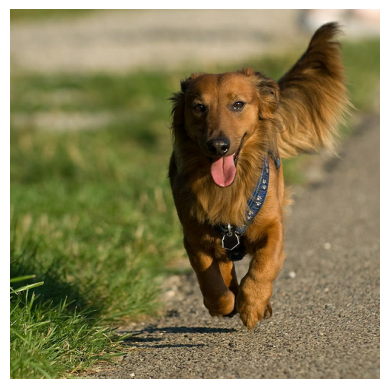

In [3]:
show_img('1089181217_ee1167f7af.jpg')

In [3]:
SIZE = (224, 224) # Docelowa wielkosc w jakiej bedziemy wczytywac obrazy

filename = "Flickr_8k.trainImages.txt"

path_to_info = "data/info_on_images/" + filename
path_to_image = "data/fetched/"

## 1.2 Stworzenie obiektu VGG16 - siec neuronowa typu _backbone_, ktora posluzy do wyciagniecia wektorow cech

In [285]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

## 1.3 Wyciagniecie wektorow cech z obrazow

In [4]:
def get_features(path_to_images, path_to_ids):
    features_vectors = {}

    with open(path_to_ids, "r") as file:
        data = file.read().splitlines()

    for image_name in data:
        image = load_img(path_to_images + image_name, target_size=SIZE)
        image = img_to_array(image)
        image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

        image = preprocess_input(image)

        feature = model.predict(image, verbose=0)

        features_vectors[image_name] = feature
    return features_vectors

## 1.4 Zapisanie _pikla_ 

In [ ]:
dump(get_features(path_to_image, path_to_info), open(os.path.join("utils", "features_inception.pkl"), "wb"))

## 1.5 Podsumowanie modelu

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# 2. Wstepne przetwarzanie danych tekstowych

## 2.1 Definicja tokenow i wyrazow do potencjalnego usuniecia (stop words, czyli _wyrazy stopu_ to takie, ktore nie wnosza kontekstu do zdania np. _a, the, on_)

Jako początek sekwencji będziemy używali tokenu _startseq_, a do zakonczenia sekwencji uzyjemy _endseq_.

In [5]:
STOP_WORDS = set(stopwords.words('english'))
BEGIN = 'startseq'
END = 'endseq'
SEP = '###'

In [6]:
def is_stop_token(text):
    """
    Funkcja sprawdzajaca, czy wyraz jest tokenem poczatkowym/koncowym.
    :param: str text - wyraz do sprawdzenia
    
    :returns: boolean True - wyraz jest tokenem stopu / boolean False - nie jest tokenem stopu
    """
    global BEGIN, END
    return text == BEGIN or text == END


def text_preprocessing(text):
    """
    Funkcja, ktora wstepnie przetwarza cala linijke textu w nastepujacej kolejnosci:
    1. Zamienia wszystkie litery na male.
    2. Zamienia kazdy znak, ktory ani nie jest alfanumeryczny, ani nie jest spacja, na pusty znak.
    3. Zamienia wiele spacji na pojedyncza spacje.
    4. Usuwa znaki biale na koncu zdania.
    5. Dodaje tokeny poczatku i konca zdania.
    
    :param: str text - linijka do przetwarzania
    
    :returns: str text - przetworzona linijka
    """
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)

    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    text = BEGIN + ' ' + text + ' ' + END
    text = list(filter(lambda x: (is_stop_token(x) or len(x) > 1) and not x.isnumeric(), text.split()))
    text = " ".join(text)

    return text


def load_file(path):
    """
    Wczytuje plik tekstowy do pamieci czytajac go calego na raz i dzieli go ze wzgledu na znaki nowej linii.
    
    :param: str path - sciezka do pliku tekstowego
    
    :returns: list[str] text - wczytany plik w postaci listy linijek z pliku
    """
    with open(path, 'r') as file:
        text = file.read().splitlines()
    return text


def get_descriptions(text):
    """
    Przeczytaj plik z opisami zdjec i zwroc slownik, ktory danemu ID przyporzadkowuje wszystkie opisy do zdjec.
    
    :param: list[str] text - lista linijek opisujacych zdjecie w nastepujacym formacie - ID# OPIS
    
    :returns: dict[str, list[str]] - slownik, ktory danemu ID (str), przyporzadkowuje liste (list[str]) opisow do
    danego zdjecia.
    """
    descriptions = {}

    for line in text:
        id, desc = re.split('#\d\s+',line)
        if id not in descriptions:
            descriptions[id] = []
        descriptions[id].append(text_preprocessing(desc))
    return descriptions


def to_bag_of_words(descriptions):
    """
    Zwraca zbior wszystkich opisow. Opisy w formie tekstow, sa zamieniane na listy, podzielone ze wzgledu na znak
    spacji.
    
    :param: dict[str, list[str]] - slownik z opisami zdjec (patrz get_descriptions)
    
    :returns: set[str] - zbior wszystkich wyrazow, ktore zostaly uzyte do opisow zdjec.
    """
    
    words = set()
    for key in descriptions.keys():
        [words.update(w.split(' ')) for w in descriptions[key]]
    return words


def save_descriptions_to_a_file(descriptions, path):
    """
    Zapisuje slownik do pliku w sciezce 'path'. Slownik zapisywany jest w nastepujacym formacie: ID{seperator}OPIS.
    
    :param: dict[str, list[str]] - slownik z opisami zdjec (patrz get_descriptions).
    :param: str path - sciezka do pliku
    
    :returns: None
    """
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + SEP + desc)
    data = '\n'.join(lines)
    file = open(path, 'w')
    file.write(data)
    file.close()

## 2.2 Wczytanie pliku z opisami do zdjec

In [7]:
filename = 'data/info_on_images/Flickr8k.token.txt'
doc = load_file(filename)

## 2.3 Ekstrakcja opisow do zdjec

In [8]:
descriptions = get_descriptions(doc)
print('Liczba wczytanych opisow: %d ' % len(descriptions))

Liczba wczytanych opisow: 8092 


## 2.4 Stworzenie slownika wszystkich slow uzytych do opisow zdjec

In [8]:
vocabulary = to_bag_of_words(descriptions)
print('Wielkosc slownika: %d' % len(vocabulary))

Wielkosc slownika: 8773


In [27]:
save_descriptions_to_a_file(descriptions, 'utils/descriptions.txt')

# 3. Przygotowanie do uczenia modelu

## 3.1 Funkcje odpowiedzialne za proces tokenizacji podczas przetwarzania tekstu

In [9]:
def create_tokenizer(description_list):
    """
    Tworzy obiekt klasy Tokenizer na podstawie listy wszystkich opisow.
    
    :param: list[str] description_list  - lista wszystkich opisow
    
    :returns: tokenizer
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(description_list)
    return tokenizer

def get_reverse_tokenizer(tokenizer: Tokenizer):
    """
    Odwraca dzialanie tokenizacji.
    Jako ze Tokenizer domyslnie, dopasowuje napis do liczby, to nalezy rowniez ten proces odwrocic, aby
    odkodowac przewidziany opis.
    
    :param: Tokenizer tokenizer - obiekt tokenizer z biblioteki keras
    
    :returns: dict[int, str] - slownik przypisowujacy liczbie, odpowiadajacy jej napis
    """
    return {v:k for (k,v) in tokenizer.word_index.items()}

#### Przyklad:

In [ ]:
tok = create_tokenizer(['A dog is running', 'A kid is playing on a playground with their dog'])
tok.word_index

Powyzej, bardzo dobrze widac, ze tokenizer nadaje nizsze indexy, tokenom ktore czesciej wystepuja w opisach.

## 3.1 Funkcje pozwalajace na podawanie opisow do modelu

Proponowane rozwiazanie uzywa _generatora_, ktory posluzy za podawanie kolejnych wartosci. Maszyna, na ktorej trenowany bedzie model ma tylko 16GB pamieci RAM, takze niemozliwe bedzie zaladowanie do pamieci na raz 6000 opisow do obrazow.

In [10]:
def generate_data(descriptions, features, tokenizer, max_length, vocab_size):
    """
    Pythonowy generator, ktory 'oddaje' sekwencje do modelu RNN (rekurencyjna siec neuronowa).
    
    :param: dict[str, list[str]] descriptions - opisy do zdjec (patrz get_descriptions)
    :param: features[str, ]
    """
    while 1:
        for key, desc_list in descriptions.items():
            feature = features[key][0]

            input_img, input_seq, output_seq = create_sequences(tokenizer, max_length, desc_list, feature, vocab_size)
            yield [[input_img, input_seq], output_seq]


def create_sequences(tokenizer, max_length, desc_list, feature, vocab_size):
    """
    Tworzy sekwencje wejściowe i wyjściowe dla opisów obrazków dla rekurencyjnych sieci neuronowych, ktore
    predykuja nastepne slowo na podstawie sekwencji. np:
    input seq: startseq a dog is 
    output seq: running

    :param: Tokenizer tokenizer -  obiekt tokenizer z biblioteki keras
    :param: int max_length: maksymalna długość sekwencji
    :param: list[str] desc_list  - lista opisów obrazków
    :param: dict[str, np.array] feature - wektor cech obrazow
    :param: int vocab_size: rozmiar słownika
    
    :return: trzy wartości: macierz z cechami obrazów, macierz sekwencji wejściowych oraz macierz sekwencji wyjściowych
    """
    photo_for_seq, input_sequences, output_for_seq = [], [], []
    
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            # input sekwencja do i-tego wyrazu, a output to i-ty wyraz
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            
            # dodaj do arrays nastepujace elementy: wektor_cech, input_sequence, output_sequence
            photo_for_seq.append(feature)
            input_sequences.append(in_seq)
            output_for_seq.append(out_seq)
    return array(photo_for_seq), array(input_sequences), array(output_for_seq)

#### Przykład

In [160]:
file_path = 'data/info_on_images/Flickr_8k.trainImages.txt'

train_images = load_file(file_path)
features = get_feature_vector(train_images, "utils/features.pkl")
descriptions = get_clean_descriptions(train_images, "utils/descriptions.txt")
flatten_description = flatten_descriptions(descriptions)
tokenizer = create_tokenizer(flatten_description)

vocab_size = size_of_vocab(tokenizer)
max_length = max_len(flatten_description)

# pojedynczy obrazek
id_obrazka = '2513260012_03d33305cf.jpg'
feature = features[id_obrazka]
desc = descriptions[id_obrazka]

a,b,c = create_sequences(tokenizer,max_length,desc,feature,vocab_size)


In [161]:
a,b,c

(array([[[0.       , 0.       , 1.7041475, ..., 0.       , 0.       ,
          0.       ]],
 
        [[0.       , 0.       , 1.7041475, ..., 0.       , 0.       ,
          0.       ]],
 
        [[0.       , 0.       , 1.7041475, ..., 0.       , 0.       ,
          0.       ]],
 
        ...,
 
        [[0.       , 0.       , 1.7041475, ..., 0.       , 0.       ,
          0.       ]],
 
        [[0.       , 0.       , 1.7041475, ..., 0.       , 0.       ,
          0.       ]],
 
        [[0.       , 0.       , 1.7041475, ..., 0.       , 0.       ,
          0.       ]]], dtype=float32),
 array([[  0,   0,   0, ...,   0,   0,   1],
        [  0,   0,   0, ...,   0,   1,  14],
        [  0,   0,   0, ...,   1,  14,   8],
        ...,
        [  0,   0,   0, ..., 532, 443, 258],
        [  0,   0,   0, ..., 443, 258,  11],
        [  0,   0,   0, ..., 258,  11,  23]], dtype=int32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ...

In [174]:
koncowka_opisu = b[-1][24:]
koncowka_opisu

array([  1,  12,  30,  31,  32, 532, 443, 258,  11,  23], dtype=int32)

In [175]:
r = get_reverse_tokenizer(tokenizer)

res = ""

for slowo in koncowka_opisu:
    res += r[slowo] + " "

In [176]:
res

'startseq two dogs running through low lying body of water '

## 3.4 Funkcje pomocnicze

Do trenowania modelu, bedziemy tez potrzebowali funkcji, ktore pozwola nam okresli dlugosc najdluzszej sekwencji, ktora model powinien generowac, wielkosc slownika (tokenizer), oraz funkcji ktora pozwoli _wyplaszczyc_ dwuwymiarowa liste, do jednowymiarowej.

In [11]:
def max_len(flattened_descriptions):
    """
    Zwraca dlugosc najdluzszego opisu do zdjec.
    
    :param: list[str] flattened_descriptions - wszystkie opisy do zdjec.
    
    :returns: int x - dlugosc najdluzszego opisu.
    """
    return max((len(l.split()) for l in flattened_descriptions))



def size_of_vocab(tokenizer):
    """
    Zwraca wielkosc slownika. 
    
    :param: Tokenizer tokenizer - obiekt tokenizer z biblioteki keras
    
    :returns: int x - wielkość docelowego słownika
    """
    return len(tokenizer.word_index) + 1

def flatten_descriptions(descriptions):
    """
    Splaszcza opisy obrazkow. Tworzy ze slownika (ktory do klucza przypisane ma wiele opisow), 
    liste jednowymiarowa tychze opisow.
    
    :param: dict[str, list[str]] descriptions - slownik opisow obrazkow (patrz get_descriptions)
    
    :returns: list[str] - slownik przypisowujacy liczbie, odpowiadajacy jej napis
    """
    return [item for sub in descriptions.values() for item in sub]

#### Przykład

In [46]:
desc = {"1":["a","b","c"],"2":["d","e","jestem wesoly"]}
flatten_descriptions(desc)

['a', 'b', 'c', 'd', 'e', 'jestem wesoly']

In [47]:
max_len(flatten_descriptions(desc))

2

# 4. Wczytanie przetworzonych danych

Potrzebujemy wczytac do pamieci _zpiklowane_ wczesniej obiekty (przetworzone opisy, wektory cech), zeby wykorzystac w procesie uczenia.

In [295]:
def get_clean_descriptions(image_ids, descriptions_path):
    """
    Zwraca zapisane opisy juz po wczesnym przetwarzaniu (patrz save_descriptions_to_file). 
    
    :param: list[str] image_ids - lista id obrazow
    :param: str descriptions_path - sciezka do pliku z opisami
    
    :returns: dict[str, list[str]] - slownik, ktory przyporzadkowuje zdjeciu wszystkie przetworzone opisy
    """
    descriptions = load_file(descriptions_path)
    descriptions = list(map(lambda x: x.split(SEP), descriptions))
    multiple_descriptions = {}
    for k,v in descriptions:
        if k not in image_ids:
            continue
        elif k not in multiple_descriptions:
            multiple_descriptions[k] = []
        multiple_descriptions[k].append(v)

    return multiple_descriptions


def get_feature_vector(image_ids, features_path):
    """
    Zwraca zapisany dziennik, ktory jest ograniczony do tych kluczy z image-ids
    
    :param: list[str] image_ids - lista id obrazow
    :param: str features_path - sciezka do pliku ze spiklowanym slownikiem
    
    :returns: dict[str, np.array] - zapisany slownik
    """
    features_vectors = load(open(features_path, 'rb'))
    return {k:v for (k,v) in features_vectors.items() if k in image_ids}

### Na podstawie poniższego pliku, będzie trenowany model, zmiana pliku na walidacyjny/testowy/treningowy pozwala wytrenować/przetestować model.

In [13]:
filename = 'data/info_on_images/Flickr_8k.trainImages.txt'

In [14]:
descriptions = get_clean_descriptions(load_file(filename), 'utils/descriptions.txt')
flatten = flatten_descriptions(descriptions)

features = get_feature_vector(descriptions.keys(), 'utils/features.pkl')
tokenizer = create_tokenizer(flatten)

length = max_len(flatten)
size = len(to_bag_of_words(descriptions))

In [52]:
dump(tokenizer, open('utils/tokenizer.pkl','wb'))

# 5. Trenowanie modelu

Ponizsza funkcja pozwala na stworzenei samego modelu. Architektura, jest zgodna z plikiem _utils/model.png_, ktory jest generowany przy tworzeniu modelu.

In [323]:
def create_model(vocab_size, max_length_of_seq):
    """
    Tworzy model zgodnie z architektura, przedstawiona w katalogu utils/model.png. Model sluzy do generacji
    opisu do obrazka podanego na wejsciu modelu przy predykcji.
    
    :param: int vocab_size - wielkosc slownika
    :param: int max_length_of_seq - maksymalna dlugosc generowanego zdania
    
    :returns: keras.model.Model - model
    """
    image_input = Input(shape=(2048,))
    image = Dropout(0.25)(image_input)
    image = Dense(256, activation='relu')(image)

    sequences_input = Input(shape=(max_length_of_seq,))
    sequences = Embedding(vocab_size, 256, mask_zero=True)(sequences_input)
    sequences = Dropout(0.25)(sequences)
    sequences = LSTM(256)(sequences)

    decoder = add([image, sequences])
    decoder = Dense(256, activation='relu')(decoder)
    output = Dense(vocab_size, activation='softmax')(decoder)

    model = Model(inputs=[image_input, sequences_input], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    plot_model(model, to_file='utils/model.png', show_shapes=True)

    return model

Potrzebna tez jest funkcja ktora pozwoli na samo trenowanie modelu. Wykorzystamy w tym celu wczesniej utworzone funkcje, miedzy innymi wczytywanie opisow, wektorow cech, tworzenia modelu itd.

Po kazdej epoce, model bedzie zapisywany w katalogu _models_.

In [321]:
def train_model(file_path, epochs, model, c=-1):
    """
    Trenuje model, w oparciu o plik z opisami w file_path. Po jednej epoce, model jest zapisywany w models/
    
    :param: str file_path - sciezka do pliku z przetworzonymi opisami
    :param: int epochs - liczba epok
    :param: keras.model.Model model - model do wytrenowania
    :param: int c - liczba obrazow, ktora jest brana pod uwage przy trenowaniu    
    :returns: None
    """
    train_images = load_file(file_path)
    
    if c != -1:
        train_images = load_file(file_path)[:c]
        
    features = get_feature_vector(train_images, "utils/features_inception.pkl")
    descriptions = get_clean_descriptions(train_images, "utils/descriptions.txt")
    flatten_description = flatten_descriptions(descriptions)
    tokenizer = create_tokenizer(flatten_description)

    vocab_size = size_of_vocab(tokenizer)
    max_length = max_len(flatten_description)
    model = create_model(vocab_size, max_length)

    steps = len(descriptions)
    for i in range(epochs):
        gen = generate_data(descriptions, features, tokenizer, max_length, vocab_size)
        model.fit_generator(gen, epochs=1, steps_per_epoch=steps,verbose=1, max_queue_size=500, use_multiprocessing=True)
        model.save('models/model_inceptionv3_V' + str(i) + '.h5')

In [318]:
filename = 'data/info_on_images/Flickr_8k.trainImages.txt'

In [319]:
SIZE = (299,299)

In [ ]:
train_model(filename, 5, create_model(size, length))

# 6. Ewaluacja

Samo wytrenowanie modelu nie wystarczy, trzeba przede wszystkim sprawdzic jego dzialanie na pojedynczym zdjeciu, oraz trzeba sprawdzic jego wydajnosc na innym zbiorze danych.

In [191]:
def predict_description(model, tokenizer: Tokenizer, photo, max_length):
    """
    Generuje tekstowy opis dla podanego obrazu, używając wytrenowanego modelu RNN.
    
    :param model: Wytrenowany model RNN używany do generowania opisów.
    :param tokenizer: Tokenizer używany do tokenizacji danych tekstowych.
    :param photo: Wejściowy obraz, dla którego ma zostać wygenerowany opis.
    :param max_length: Maksymalna długość wygenerowanego opisu.
    :return: Przewidywany tekstowy opis dla podanego obrazu.
    """

    input = BEGIN
    reversed_tokenizer = get_reverse_tokenizer(tokenizer)
    for i in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([input])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        y_predict = model.predict([photo, sequence], verbose=0)
        y_predict = argmax(y_predict)

        predicted_word: str = reversed_tokenizer[y_predict]

        if predicted_word == None:
            break

        input += " " + predicted_word

        if predicted_word == END:
            break
    prediction = input
    prediction = " ".join(prediction.split(" ")[1:-1]).capitalize()
    return prediction

def get_clean_descriptions(filename, photo_ids):
    descs = get_descriptions(load_file(filename))
    return {k:v for (k,v) in descs.items() if k.split('.')[0] in photo_ids}

def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    """
    Ocenia model poprzez porównanie przewidywanych opisów z rzeczywistymi opisami dla podanych danych.
    
    :param model: Model RNN, który ma być oceniany.
    :param descriptions: Słownik opisów dla poszczególnych zdjęć.
    :param photos: Słownik zdjęć, dla których mają być generowane opisy.
    :param tokenizer: Tokenizer używany do tokenizacji danych tekstowych.
    :param max_length: Maksymalna długość generowanego opisu.
    """
    y, y_pred = [], []
    for k, desc_list in descriptions.items():
        predicted_description = predict_description(model, tokenizer, photos[k], max_length)
        refs = [desc.split() for desc in desc_list]
        y.append(refs)
        y_pred.append(predicted_description.split())
    print('BLEU-1: %f' % corpus_bleu(y, y_pred, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(y, y_pred, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(y, y_pred, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(y, y_pred, weights=(0.25, 0.25, 0.25, 0.25)))
    
def get_photo_ids(filename):
    text = load_file(filename)
    return [i.split('.')[0] for i in text]

def extract_features(path_image, model):
    image = load_img(path_image, target_size=SIZE)
    image = img_to_array(image)
    image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

    image = preprocess_input(image)

    return model.predict(image, verbose=0)

#### Ekstrakcja wektora cech

#### VGG16

In [192]:
extractor = VGG16()
extractor = Model(inputs=extractor.inputs, outputs=extractor.layers[-2].output)

#### InceptionV3

In [126]:
extractor = InceptionV3()
extractor = Model(inputs=extractor.inputs, outputs=extractor.layers[-2].output)

In [193]:
photo = extract_features('./dog.jpg', extractor)
photo

array([[0.       , 0.       , 4.7995973, ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

#### Predykcja podpisu do obrazka

In [274]:
model = load_model('models/model_vgg.h5')
path_to_img = './dog.jpg'

tokenizer = load(open('utils/tokenizer.pkl', 'rb')) # wciągnięcie słownika i tokenów

predict_description(model, tokenizer, photo, length)

'Dog is running through the grass'

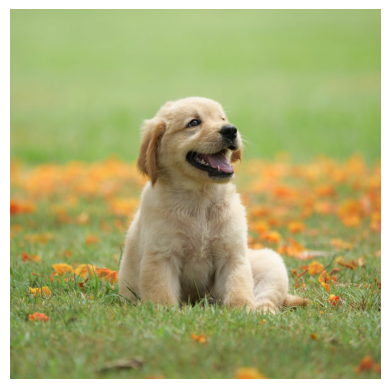

In [27]:
plt.axis('off')
plt.imshow(decode_jpeg(read_file('dog.jpg'), channels=3));

# Wnioski

Jak widać, model dość dobrze poradził sobie z predykcją podpisu do wyżej pokazanego obrazka.

Widać, że poradził sobie z rozpoznaniem psa, jak i trawy. Nie poradził sobie natomiast z rozpoznaniem ruchu wykonywanego przez psa. Może być to spowodowane obrazami, na podstawie których model był uczony. 

Jeśli większość psów, które model dostawał w procesie uczenia, wykonywała czynność biegania, to też model z większą pewnością, był w stanie stwierdzić, że jeśli na obrazie już zlokalizował psa, to też pewnie ten pies będzie biegł. 

Aby temu zapobiec, należałoby zwiększyć liczbę obiektów, na podstawie których model był uczony. Jest to jeden z wielu przypadków, które zapewne można zaobserwować (_więcej w sekcji Przykłady_).

In [ ]:
model = VGG16()
model = Model(inputs=model.input, outputs=model.layers[-2].output)

In [287]:
test_path = 'data/info_on_images/Flickr_8k.testImages.txt'
descriptions_path =  'data/info_on_images/Flickr8k.token.txt'
ids = get_photo_ids(test_path)
descs = get_clean_descriptions(descriptions_path, ids)
features = get_features('data/fetched/', test_path)

In [288]:
model = load_model('models/model_vgg.h5')

In [289]:
evaluate_model(model, descs, features, tokenizer, length)

BLEU-1: 0.330521
BLEU-2: 0.168503
BLEU-3: 0.109997
BLEU-4: 0.046214


Jak widać, na podstawie powyższych wyników, ciężko stwierdzić, czy wydajność modelu jest wystarczająca. Metryka BLEU, pozwala na ewaluacje jakości modelu translacyjnego. Mierzy ona podobieństwo między wygenerowanym przez maszynę tekstem, oraz tekstem referencyjnym, przy użyciu n-gramów. W tym przypadku, widzimy że model był w stanie poprawnie wygenerować 23% bigramów, czyli par tokenów, które się pokrywały z tekstem referencyjnym.

# 7. Przykłady dzialania modelu

In [252]:
from random import choice
count = 4
path = 'data/fetched'
ids = [choice(os.listdir(path)) for _ in range(count)]
ids

['2805873509_4f68afc4b4.jpg',
 '3516285214_59823b341e.jpg',
 '3192311620_99bda27fbd.jpg',
 '2662262499_3cdf49cedd.jpg']

2805873509_4f68afc4b4.jpg#0	A guy with a backpack on .

2805873509_4f68afc4b4.jpg#1	A hiker is standing by a mound of rocks on the path .

2805873509_4f68afc4b4.jpg#2	A man hikes up a rocky hill .

2805873509_4f68afc4b4.jpg#3	A man with a backpack on a hill next to a rock outcroping .

2805873509_4f68afc4b4.jpg#4	A man with a backpack stands beside a rock .



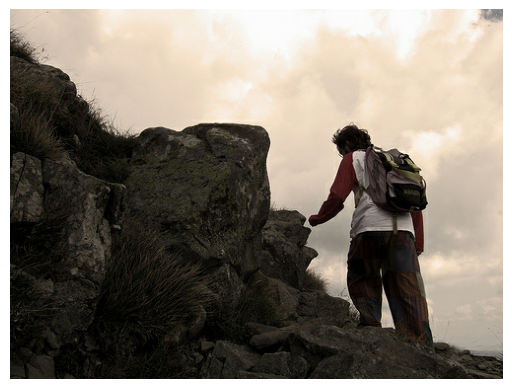

In [253]:
identyfikator = ids[0]
show_img(identyfikator)

In [254]:
predict_description(model, tokenizer, extract_features(path+'/'+identyfikator, extractor), 34)

'Man in red shirt is climbing up rock face'

3516285214_59823b341e.jpg#0	A person surfs in the curl of a wave , obsured by the falling water .

3516285214_59823b341e.jpg#1	A person surfs through a wave as it crashes down .

3516285214_59823b341e.jpg#2	A surfer is riding in the barrel of a wave .

3516285214_59823b341e.jpg#3	Someone is surfing underneath a wave on a white surfboard .

3516285214_59823b341e.jpg#4	The large wave is crashing down over a surfer .



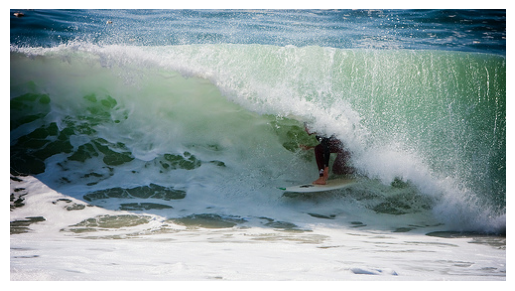

In [255]:
identyfikator = ids[1]
show_img(identyfikator)

In [256]:
predict_description(model, tokenizer, extract_features(path+'/'+identyfikator, extractor),210)

'Man in blue bathing suit is swimming in the water'

3192311620_99bda27fbd.jpg#0	A brown dog is about to catch a treat .

3192311620_99bda27fbd.jpg#1	A brown dog opens his mouth to catch a piece of food .

3192311620_99bda27fbd.jpg#2	A dog is about to catch a treat in his mouth .

3192311620_99bda27fbd.jpg#3	A dog opens its mouth to catch a treat

3192311620_99bda27fbd.jpg#4	The dog is catching a treat .



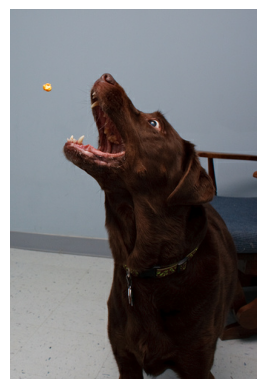

In [257]:
identyfikator = ids[2]
show_img(identyfikator)

In [258]:
predict_description(model, tokenizer, extract_features(path+'/'+identyfikator, extractor), length)

'Dog is running through the grass'

2662262499_3cdf49cedd.jpg#0	A baseball hitter holding a bat falling down .

2662262499_3cdf49cedd.jpg#1	A baseball player runs on the field .

2662262499_3cdf49cedd.jpg#2	A boy at bat playing a baseball game falls to the ground while onlookers watch .

2662262499_3cdf49cedd.jpg#3	A child in a uniform is falling to the ground with a bat in his or her hand .

2662262499_3cdf49cedd.jpg#4	This baseball player , dressed in red and white uniform and holding a bat , is falling after being hit by a pitch .



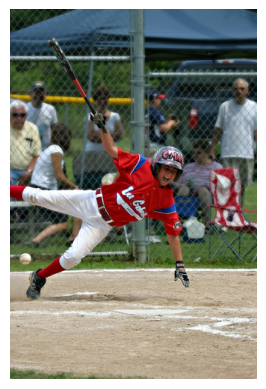

In [259]:
identyfikator = ids[3]
show_img(identyfikator)

In [260]:
predict_description(model, tokenizer, extract_features(path+'/'+identyfikator, extractor), length)

'Two men are playing soccer'

Jak widać model poprawnie potrafił rozpoznać główne obiekty na obrazie. Ze względu na ograniczenia sprzętowe, jest to model, który był trenowany dwie epoki. Wraz z kolejnymi epokami, model potrafiłby coraz lepiej dostrzegać szczegóły obrazu.

# 8. Wykorzystane modele i przykłady użycia

Prócz modelu _VGG16_, do wyciągania wektorów cech, wykorzystamy również model _InceptionV3_ i porównamy wyniki, które owe modele generują. Oba te modele są tzw. modelami typu _backbone_, czyli wcześniej wytrenowanych potężnych modeli głębokiego uczenia, które w tym przykłady posłużą do wcześniej wspomnianej ekstrakcji cech.

Poniżej przedstawiono poglądowe architektury poniższych modeli. Należy zwrócić jednak uwagę, że w naszym wypadku, jako że używamy tych modeli do ekstrakcji wektora cech, to ostatnia warstwa jest odłączona od modelu.

# 8.1 Architektura VGG16

Architektura: VGG16 ma bardzo prostą i jednolitą architekturę, składającą się z 16 warstw, w tym 13 warstw konwolucyjnych (oznaczanych jako Conv) i 3 warstw w pełni połączonych (oznaczanych jako Dense). Model VGG16 został wstępnie wytrenowany na dużym zbiorze danych ImageNet, który zawiera ponad milion obrazów z 1000 różnych klas. Model VGG16 jest ogromnym tworem o ponad 130 milionach parametrów.

VGG16 jest często używany jako model bazowy w zadaniach transferu uczenia (ang. transfer learning), gdzie wagi wstępnie wytrenowanej sieci są wykorzystywane do ekstrakcji cech z obrazów i dalszego trenowania na mniejszych zbiorach danych dla specyficznego zadania, tak jak w naszym przypadku.

Przy naszym zastosowaniu, należy zwrócić uwagę, że pomijamy ostatnią warstwę typu _dense_.

<div style="text-align:center">
    <img src="utils/vgg16.png" alt="Image" width="600">
</div>


# 8.2 Architektura InceptionV3

InceptionV3 jest jednym z wielu zaawansowanych modeli sieci neuronowych do analizy obrazów. Opracowany został przez zespół badawczy Google w 2015 roku. Jest rozwinięciem poprzednich modeli Inception i wykorzystuje architekturę konwolucyjną do przetwarzania obrazów.

InceptionV3 osiąga bardzo dobre wyniki w wielu popularnych zadaniach związanych z analizą obrazów, takich jak klasyfikacja obrazów czy detekcja obiektów. Dzięki swojej architekturze i zdolności do wykrywania cech o różnych skalach, model ten jest w stanie dokładnie rozpoznawać obiekty na obrazach.

Mimo, że uważany za duży model, ten zawiera _tylko_ (aż) 23 miliony parametrów. Należy też zwrócić uwagę, że przy naszym zastosowaniu, pomijamy ostatnią warstwę typu _dense_.

<div style="text-align:center">
    <img src="utils/inception.png" alt="Image" height=200>
</div>


# 8.3 Przykłady opisu do zdjęcia według modelu

#### InceptionV3

In [368]:
extractori = InceptionV3()
extractori = Model(inputs=extractori.inputs, outputs=extractori.layers[-2].output)

## 8.3.1 VGG16

In [412]:
extractor = VGG16()
extractor = Model(inputs=extractor.inputs, outputs=extractor.layers[-2].output)
SIZE=(224,224)

In [413]:
model = load_model('models/model_vgg.h5')

In [398]:
os.listdir('data/fetched')

['3532205154_5674b628ea.jpg',
 '2198511848_311d8a8c2f.jpg',
 '2579460386_94c489028d.jpg',
 '3572267708_9d8a81d4a4.jpg',
 '2592019072_a6c0090da4.jpg',
 '430803349_a66c91f64e.jpg',
 '3704698586_a42c25d0c1.jpg',
 '2643263887_a32ffb878f.jpg',
 '1418019748_51c7d59c11.jpg',
 '3286111436_891ae7dab9.jpg',
 '2044063458_fcc76a7636.jpg',
 '3051341320_1d0166e775.jpg',
 '775664534_3f6de7d413.jpg',
 '136644343_0e2b423829.jpg',
 '2021602343_03023e1fd1.jpg',
 '557101732_32bbc47c12.jpg',
 '3399944164_ec24123945.jpg',
 '3534952095_975cca0056.jpg',
 '2896180326_88785fe078.jpg',
 '2315867011_fc5fc9fa6d.jpg',
 '3503011427_a4ee547c77.jpg',
 '2057305043_952b8dc82c.jpg',
 '3477681171_b1bb8b211d.jpg',
 '1339596997_8ac29c1841.jpg',
 '2347921097_f2e35753c0.jpg',
 '3694093650_547259731e.jpg',
 '3163477256_073605e06e.jpg',
 '3021318991_fa28e3bca7.jpg',
 '3265578645_4044a7049a.jpg',
 '3681414069_71ba164f71.jpg',
 '3512791890_eb065b460a.jpg',
 '3075068274_2a28a5263b.jpg',
 '3393152604_27bd1037f2.jpg',
 '2874728371_c

In [418]:
identyfikator = '2594336381_a93772823b.jpg'
path = path_to_image + identyfikator

2594336381_a93772823b.jpg#0	A little boy with a dirty face lays on a colorful rug .

2594336381_a93772823b.jpg#1	A little boy with a messy face sitting on a colorful blanket .

2594336381_a93772823b.jpg#2	little boy in red shirt and gray shorts with messy face

2594336381_a93772823b.jpg#3	The little boy is laying back relaxing on the colorful blanket .

2594336381_a93772823b.jpg#4	There is a little boy in a red shirt and a dirty face and he is smiling .



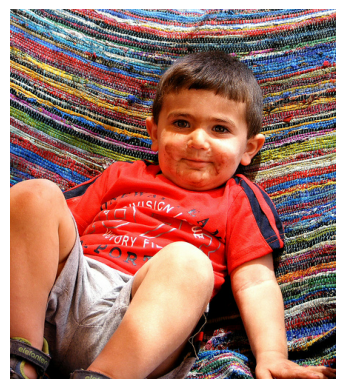

In [419]:
show_img(identyfikator)

In [420]:
predict_description(modelvgg, tokenizer, extract_features(path, extractor), length)

'Two children are playing in the water'

## 8.3.1 InceptionV3

In [405]:
model = load_model('models/model_inceptionv3_V1.h5')
extractor = InceptionV3()
extractor = Model(inputs=extractor.input, outputs=extractor.layers[-2].output)
SIZE = (299,299)

1689658980_0074d81d28.jpg#0	The two dogs are enjoying a run through the surf .

1689658980_0074d81d28.jpg#1	Two dogs are running through the surf .

1689658980_0074d81d28.jpg#2	Two dogs play in the surf .

1689658980_0074d81d28.jpg#3	Two dogs running through the water on a beach .

1689658980_0074d81d28.jpg#4	Two dogs run out of the ocean lake .



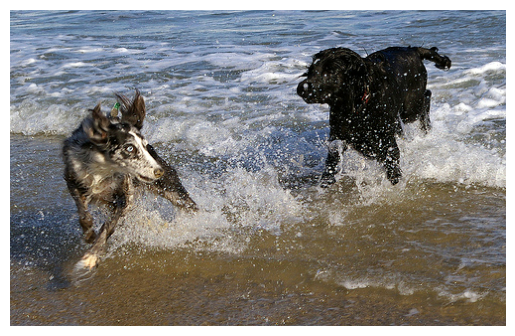

In [406]:
show_img(identyfikator)

In [407]:
predict_description(model, tokenizer, extract_features(path, extractor), length)

'Two people are sitting on the beach'

# Wnioski

Jak widać, model VGG16 potrafił rozpoznać psa na zdjęciu. Jednak nie poradził sobie z licznością obiektów. W przypadku modelu InceptionV3, ten znacznie lepiej poradził sobie z licznością, jednak nie poradził sobie z rozpoznaniem obiektu.

# 8.4 Metryki BLEU po wytrenowaniu dla całego zbioru danych

In [ ]:
path = 'data/info_on_images/'
test_path = path + 'Flickr_8k.testImages.txt'
train_path = path + 'Flickr_8k.trainImages.txt'
dev_path = path + 'Flickr_8k.devImages.txt'
descriptions_path =  'data/info_on_images/Flickr8k.token.txt'

ids = get_photo_ids(train_path)
ids.extend(get_photo_ids(test_path))
ids.extend(get_photo_ids(dev_path))

descs = get_clean_descriptions(descriptions_path, ids)

In [ ]:
model = VGG16()
model = Model(inputs=model.input, outputs=model.layers[-2].output)

dump(get_features(path_to_image, path_to_info), open(os.path.join("utils", "features.pkl"), "wb"))

In [ ]:
model = InceptionV3()
model = Model(inputs=model.input, outputs=model.layers[-2].output)

dump(get_features(path_to_image, path_to_info), open(os.path.join("utils", "features_inception.pkl"), "wb"))

##  8.4.1 VGG16

In [ ]:
extracted_features = load(open('utils/features.pkl','rb'))

In [ ]:
model = load_model('models/model_vgg.h5')

In [ ]:
evaluate_model(model,descs,extracted_features,tokenizer,length)

## 8.4.2 InceptionV3

In [ ]:
extracted_features = load(open('utils/features_inception.pkl','rb'))

In [ ]:
model = load_model('models/model_inceptionv3_V3')

In [ ]:
evaluate_model(model,descs,extracted_features,tokenizer,length)